In [1]:
import numpy as np
import pandas as pd
from CHEM274.importer_snippets import load_experiment
from LinReg import PolyReg
from scipy.signal import find_peaks, savgol_filter
import matplotlib.pyplot as plt
plt.style.use('JGW-PPT')
import os
os.getcwd()

'C:\\Users\\jgage\\Documents\\GitHub\\CHEM274\\Cdl-fitting'

In [5]:
# Import Data
exp100 = load_experiment(csv_dirname=r"..\data\CV_Fc_GC_MeCN_0.1Vs-1_P-06-19")
exp150 = load_experiment(csv_dirname=r"..\data\CV_Fc_GC_MeCN_0.15Vs-1_P-06-22")
exp200 = load_experiment(csv_dirname=r"..\data\CV_Fc_GC_MeCN_0.2Vs-1_P-06-20")
exp250 = load_experiment(csv_dirname=r"..\data\CV_Fc_GC_MeCN_0.25Vs-1_P-06-23")
exp300 = load_experiment(csv_dirname=r"..\data\CV_Fc_GC_MeCN_0.3Vs-1_P-06-21")
# exp400 = load_experiment()
exp400 = None

exp_series = [exp100, exp150, exp200, exp250, exp300, exp400]

# For MeCN, there is no 400 mV/s point.
exp_series.pop()
# for exp in exp_series:
#     print(exp.params.loc[exp.params['parameter']=='scan_rate', 'value'])

In [6]:
for exp in exp_series:
    # All Cdl measurements were taken week 4, so apply reference calibration. E_program is left unchanged.
    exp.data['Ecell'] = exp.data['Ecell'] - 0.094010

    # Figure out what the real h_time was. This is different from the programmed h_time due to automatic sample number rounding during acquisition.
    h_pot = exp.data.loc[0, 'E_program']
    h_time = exp.data.loc[exp.data['E_program'] > h_pot]['t'].min()
    # Put it in params
    h_time_row = pd.Series(['h_time', h_time], index=['parameter', 'value'])
    exp.params = exp.params.append(h_time_row, ignore_index=True)

    # Separate forward and reverse scans.
    scan_direction_bools = []
    # for i in range(len(exp.data['E_program'])):
    # # This checks every data point individually, so it's a bit slow
    #     if exp.data.loc[i, 't'].item() < exp.params.loc[exp.params['parameter']=='h_time', 'value'].item():
    #         scan_direction_bools.append(None)
    #     elif i == 0:
    #         scan_direction_bools.append(True)
    #     elif exp.data['E_program'][i - 1]  < exp.data['E_program'][i]:
    #         scan_direction_bools.append(True)
    #     else:
    #         scan_direction_bools.append(False)

    '''
    It seems that there is so much noise in Ecell and such a delay between E_program and Ecell that the only way to separate forward and reverse scans is by time.
    '''
    Ecell_lead_time = .200 # Manually set delay parameter in seconds
    switching_time = (h_time + exp.data['t'].max()) / 2 - Ecell_lead_time
    for i in range(len(exp.data['E_program'])):
        # This checks every data point individually, so it's a bit slow
        if exp.data.loc[i, 't'].item() < h_time:
            scan_direction_bools.append(None)
        elif exp.data.loc[i, 't'].item() < switching_time:
            scan_direction_bools.append(True)
        else:
            scan_direction_bools.append(False)

    exp.data['forward'] = scan_direction_bools

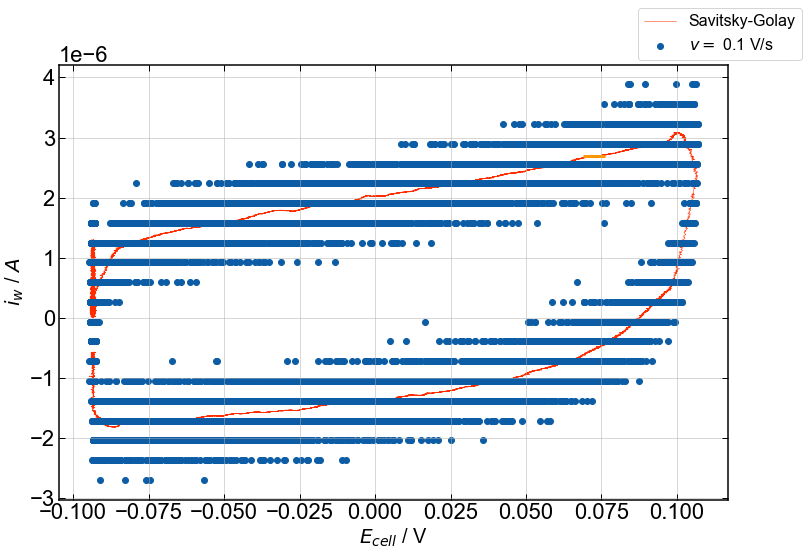

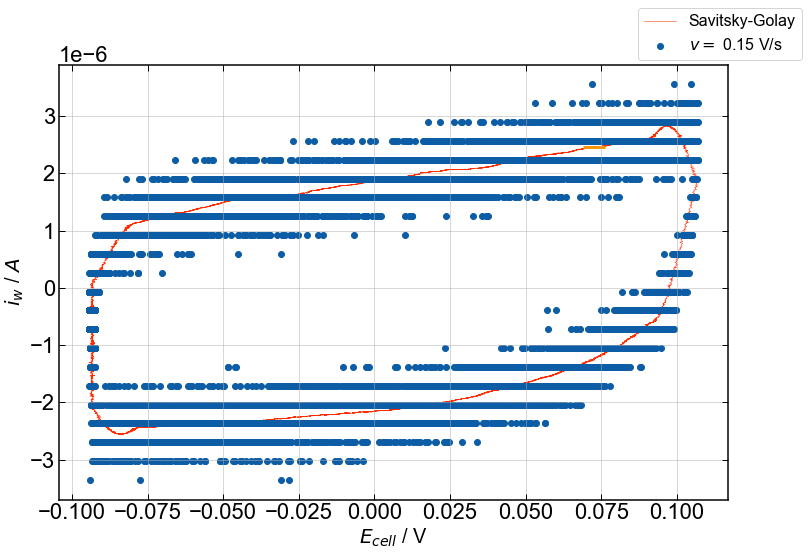

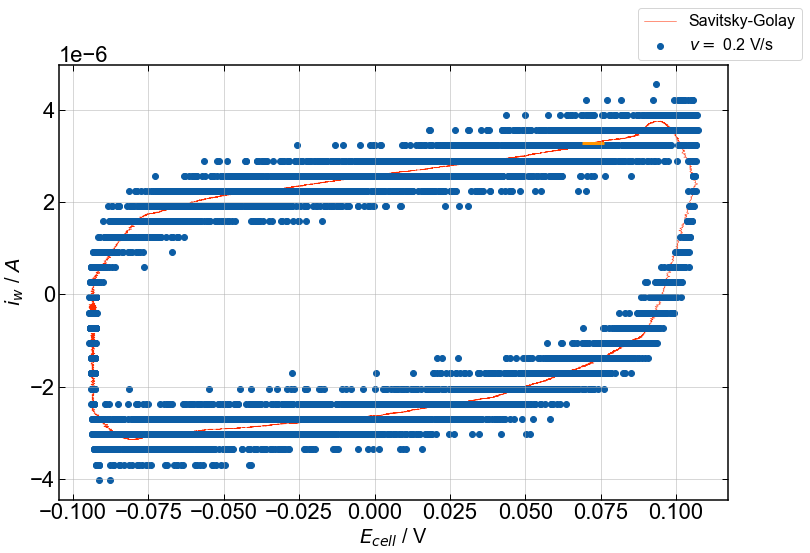

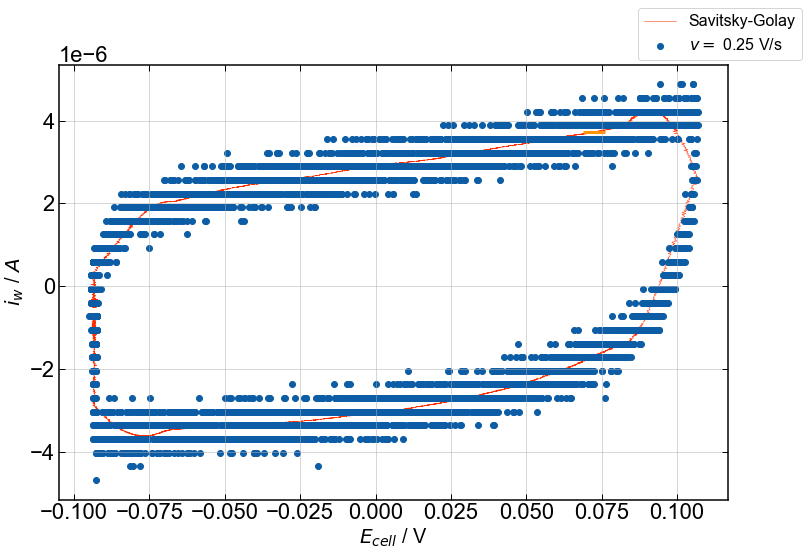

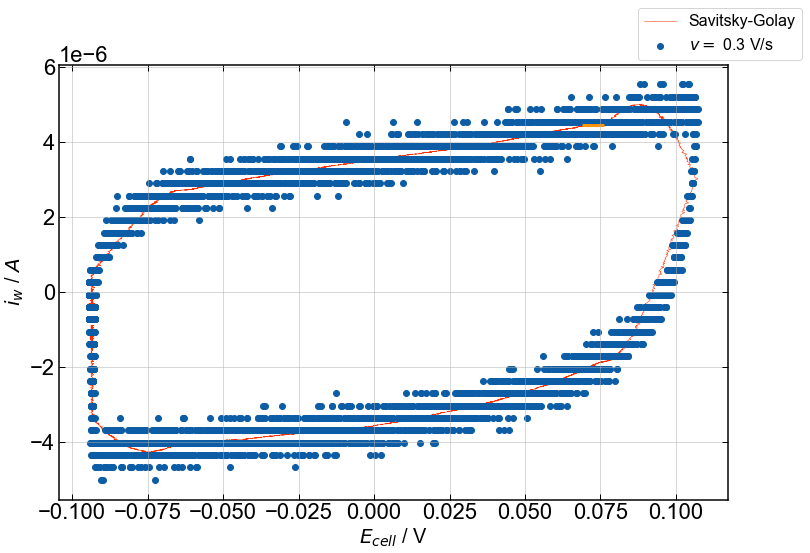

In [7]:
ic_list = []
for exp in exp_series:
    exp.data['savgol_iw'] = savgol_filter(exp.data['iw'], 725, 3)

    # Average a few points together near the end
    left_bound, right_bound = .070, 0.075
    filter = exp.data[exp.data['forward'] == True]['Ecell'].between(left_bound, right_bound)
    ic = exp.data.loc[exp.data[exp.data['forward'] == True].index.where(filter).dropna()]['savgol_iw'].mean()
    ic_list.append(ic)

    # Check the fits
    fig = plt.figure()
    ax = fig.add_subplot()

    ax.scatter(exp.data['Ecell'], exp.data['iw'], label = '$v=$ '+str(exp.params.loc[exp.params['parameter']=='scan_rate', 'value'].item()) + ' V/s')
    ax.plot(exp.data['Ecell'], exp.data['savgol_iw'], color='C1', label='Savitsky-Golay', lw=.5, zorder=.5)
    ax.scatter((left_bound+right_bound)/2, ic, c='C03', marker='_', s=500, zorder=1)
    ax.set_xlabel('$E_{cell}$ / V')
    ax.set_ylabel('$i_{w}$ / $A$')

    ax.tick_params(axis='both', which='both', direction='in', right=True, top=True)
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    fig.legend()

    # fig = plt.figure()
    # ax = fig.add_subplot()
    #
    # ax.scatter(f['Ecell'], f['iw'])

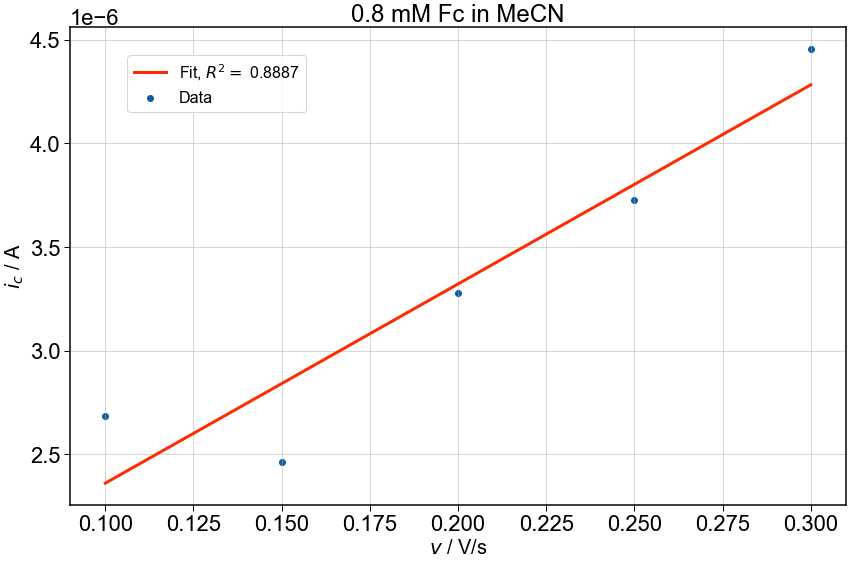

coef_deg1       9.617391e-06
std_err_deg1    1.965380e-06
coef_deg0       1.397876e-06
std_err_deg0    4.169202e-07
r_squared       8.886635e-01
s_y             3.107539e-07
dtype: float64

In [8]:
scan_rates = []
for exp in exp_series:
    scan_rates.append(exp.params.loc[exp.params['parameter']=='scan_rate', 'value'].item())

x, y = scan_rates, ic_list

fit = PolyReg(x, y, 1)

fig, ax = plt.subplots()

ax.scatter(x, y, label='Data')
ax.plot(x, fit.eval(x), label='Fit, $R^2 =$ '+ '{:.4f}'.format(fit.r_squared), color='C01')

ax.set_xlabel('$v$ / V/s')
ax.set_ylabel('$i_{c}$ / A')
ax.set_title('0.8 mM Fc in MeCN')

ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

fig.tight_layout()
fig.legend(loc=(0.15, 0.80))
plt.show()

fit.report()

#####

In [9]:
fig.savefig('Cdl-0.8 mM Fc in MeCN.png')